In [2]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
# celebrity_data = datasets.CelebA(root='./data', download=True, transform=transform)
# Load the training set
celebrity_train = datasets.CelebA(root='./data', split='train', download=True, transform=transform)

# Load the test set
celebrity_test = datasets.CelebA(root='./data', split='test', download=True, transform=transform)

In [4]:
# class VAE(nn.Module):
#     def __init__(self, latent_dim=256):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim

#         # Encoder, assume images are 64x64 pixels
#         self.conv1=nn.Conv2d(3, 32, kernel_size=3, stride=2)
#         self.bn1=nn.BatchNorm2d(32)
#         self.relu1=nn.ReLU()

#         self.conv2=nn.Conv2d(32, 64, kernel_size=3, stride=2)
#         self.bn2=nn.BatchNorm2d(64)
#         self.relu2=nn.ReLU()

#         self.fc_mean = nn.Linear(7 * 7 * 64)


class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1), # 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        self.fc_mu = nn.LazyLinear(self.latent_dim)
        self.fc_log_var = nn.LazyLinear(self.latent_dim)

        self.fc_decoder=nn.LazyLinear(16384, bias=False)

        # Decoder
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 64x64
            nn.Tanh()
        )


    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        # print(f"x shape before mu, log var {x.shape}")
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        # print(f"debug encode x shape: {x.shape} \n mu shape {mu.shape} \n log_var shape {log_var}")
        # print(f"after encode: x {x.shape}")
        return mu, log_var

    def decode(self, z):
        # print(f"starting decode z tensor {z.shape}")
        z = self.fc_decoder(z)
        # print(f"z fc decode successful {z.shape}")
        # print(f"debug: z-shape: {z.shape}")
        z = z.view(z.size(0), 1024,4,4)
        x = self.decoder(z)
        return x

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # print(f"before forward: x shape {x.shape}")
        mu, log_var = self.encode(x)
        # print(f"mu shape: {mu.shape} \n log_var shape: {log_var.shape}")
        z = self.reparameterize(mu, log_var)
        # print(f"reparameterized z shape: {z.shape}")
        x_hat = self.decode(z)
        # print(f"decoded x shape: {x_hat.shape}")
        return x_hat, mu, log_var
    



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.LazyLinear(1)
            # nn.Sigmoid()  # Add only if using BCELoss, otherwise omit
        )

    def forward(self, x):
        # print(f"cnn starting forward: x shape {x.shape}")
        x = self.conv(x)
        # print(f"cnn done fwd x shape {x.shape}")
        return x

In [ ]:

train_loader = DataLoader(celebrity_train, batch_size=64, shuffle=True, num_workers=16)
test_loader = DataLoader(celebrity_test, batch_size=64, shuffle=False, num_workers=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

vae = VAE()
cnn = CNN()

vae.to(device)
cnn.to(device)

loss = torch.nn.BCELoss()

# optim_cnn = torch.optim.Adam(cnn.parameters(), lr=0)

# optim_vae = torch.optim.Adam(vae.parameters(), lr=0)
optim_cnn = torch.optim.Adam(cnn.parameters(), lr=5e-4)
optim_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)

scheduler_cnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_cnn, 'min', factor=0.5, patience=5, threshold=0.001, cooldown=0,min_lr=0.0001)

scheduler_vae= torch.optim.lr_scheduler.ReduceLROnPlateau(optim_vae, 'min', factor=0.5, patience=5, threshold=0.001, cooldown=0,min_lr=0.0001)

# def vae_loss(reconstructed, original, mu, log_var):
#     # Reconstruction + KL divergence losses
#     recon_loss = F.mse_loss(reconstructed, original, reduction='sum')
#     kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return recon_loss + kl_div
def vae_loss(reconstructed, original, mu, log_var):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean') * original.size(0)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / original.size(0)
    return recon_loss + kl_div
epochs = 20

for epoch in range(epochs):
    print(f"epoch: {epoch}")
    cnn.train()
    vae.train()

    total_cnn_loss = 0
    total_vae_loss = 0

    for batch_index, (data, _) in enumerate(train_loader):
            data = data.to(device)
            bsize = data.shape[0]

            real_labels = torch.ones(data.size(0),1,device=device)
            fake_labels= torch.zeros(data.size(0),1,device=device)
        
            # train vae
            x_hat, mu, log_var= vae(data)
            
            loss_vae = vae_loss(x_hat, data, mu, log_var)
            
            pred_fake = cnn(x_hat.detach())
            g_loss_adv = F.binary_cross_entropy_with_logits(pred_fake, fake_labels)

            vae_loss_total = loss_vae + 1e-3 * g_loss_adv

            optim_vae.zero_grad()
            vae_loss_total.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optim_vae.step()

            #train cnn

            pred_real = cnn(data)
            pred_fake = cnn(x_hat.detach())

            cnn_real_loss = F.binary_cross_entropy_with_logits(pred_real, real_labels)

            cnn_fake_loss = F.binary_cross_entropy_with_logits(pred_fake, fake_labels)

            cnn_total_loss = (cnn_real_loss+cnn_fake_loss)/2

            optim_cnn.zero_grad()
            cnn_total_loss.backward()
            torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm=1.0)
            optim_cnn.step()

            total_vae_loss += vae_loss_total.item()
            total_cnn_loss += cnn_total_loss.item()
        

    print(f"[{epoch}] VAE Loss: {total_vae_loss:.2f}, CNN Loss: {total_cnn_loss:.2f}")
    scheduler_cnn.step(total_cnn_loss)
    scheduler_vae.step(total_vae_loss)
    

device: cuda
epoch: 0
[0] VAE Loss: 40344.99, CNN Loss: 44.13
epoch: 1
[1] VAE Loss: 32988.30, CNN Loss: 1.70
epoch: 2
[2] VAE Loss: 32840.60, CNN Loss: 1.27
epoch: 3
[3] VAE Loss: 32721.39, CNN Loss: 0.49
epoch: 4
[4] VAE Loss: 32696.14, CNN Loss: 0.79
epoch: 5
[5] VAE Loss: 32642.02, CNN Loss: 0.89
epoch: 6
[6] VAE Loss: 32638.54, CNN Loss: 0.35
epoch: 7
[7] VAE Loss: 32602.95, CNN Loss: 0.45
epoch: 8
[8] VAE Loss: 32574.29, CNN Loss: 0.32
epoch: 9
[9] VAE Loss: 32558.44, CNN Loss: 0.60
epoch: 10
[10] VAE Loss: 32547.77, CNN Loss: 0.55
epoch: 11
[11] VAE Loss: 32560.57, CNN Loss: 0.25
epoch: 12
[12] VAE Loss: 32524.57, CNN Loss: 0.33
epoch: 13
[13] VAE Loss: 32496.43, CNN Loss: 0.00
epoch: 14
[14] VAE Loss: 32500.50, CNN Loss: 1.06
epoch: 15
[15] VAE Loss: 32496.22, CNN Loss: 0.02
epoch: 16
[16] VAE Loss: 32489.05, CNN Loss: 0.33
epoch: 17
[17] VAE Loss: 32465.52, CNN Loss: 0.39
epoch: 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.696195..0.6857343].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86620677..0.6629883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7352525..0.80443454].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data

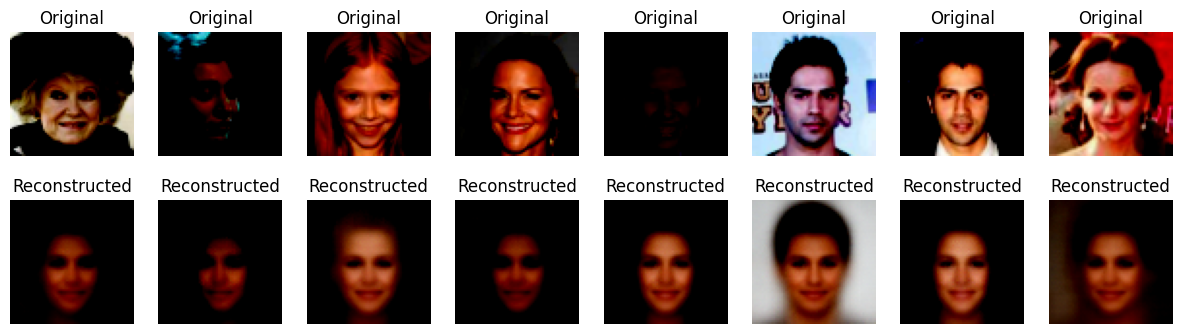

In [ ]:
import matplotlib.pyplot as plt

vae.eval()
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon, _, _ = vae(data)
        
        # Display original and reconstructed examples
        n = 8  # number of images to display
        fig, axes = plt.subplots(2, n, figsize=(15, 4))
        for i in range(n):
            axes[0, i].imshow(data[i].permute(1, 2, 0).cpu().numpy())
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(recon[i].permute(1, 2, 0).cpu().numpy())
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()
        break  # just one batch

In [ ]:
total_mse = 0
vae.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, _, _ = vae(data)
        mse = F.mse_loss(recon, data, reduction='sum')  # total across batch
        total_mse += mse.item()

avg_mse = total_mse / len(celebrity_test)  # assuming test dataset is sized
print(f"Average Reconstruction MSE on Test Set: {avg_mse:.4f}")

image_dim = 3 * 64 * 64
normalized_mse = avg_mse / image_dim
print(f"Normalized MSE per pixel: {normalized_mse:.4f}")

Average Reconstruction MSE on Test Set: 1862.8218
Normalized MSE per pixel: 0.1516
